## graph convolutional network using co-author graph
This demonstrates the construction and training of the graph convolutional network.   it loads the co-author graph which has the augmented e-vector node data property from an saved model that is generated by fun-with-coauthor-graph.ipynb.  


In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import numpy as np
import networkx as nx
#from res.plot_lib import set_default
import matplotlib.pyplot as plt
%matplotlib inline

Using backend: pytorch


In [2]:
from dgl.data.utils import load_graphs
col = load_graphs("./coau-model")

In [3]:
co = col[0]

In [4]:
co = co[0]

In [101]:
co

DGLGraph(num_nodes=18333, num_edges=327576,
         ndata_schemes={'feat': Scheme(shape=(6805,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'e_vector': Scheme(shape=(100,), dtype=torch.float64), 'h': Scheme(shape=(100,), dtype=torch.float64)}
         edata_schemes={})

In [5]:
features = th.zeros((18333, 100))
print(features.shape)
for i in range(18333):
    features[i] = th.tensor(co.ndata['e_vector'][i])

torch.Size([18333, 100])


C:\Users\ganno\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [6]:
cofull = np.load('C:/Users/ganno/.dgl/gnn_benckmark/ms_academic_cs.npz', allow_pickle=True)

In [7]:
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import pickle 
filehandler = open('gensim_model', 'rb') 
model = pickle.load(filehandler)

In [8]:
mar = np.zeros((model.docvecs.count, 100))
for i in range(model.docvecs.count):
    x = np.linalg.norm(model.docvecs[i])
    mar[i] = model.docvecs[i]/x

The following is a digression.   it is interesting to look at the shortest path through the authors.   one of the remarkable things about this graph is that it is completely connected.   we can also see how two authors from very different disciplines are related.  

In [10]:
def find_authors_by_topic(coau, topic):
    authors = []
    for i in range(len(cofull['labels'])):
        l = coau.ndata['label'][i]
        if cofull['class_names'][l]  == topic:
            authors.append(i)
    return authors
   

In [12]:
theory = find_authors_by_topic(co, 'theoretical_cs')

In [13]:
networks = find_authors_by_topic(co, 'networks')

In [15]:
cox = co.to_networkx()

In [20]:
p = nx.shortest_path(cox, theory[1], networks[2])
[cofull['class_names'][co.ndata['label']][j] for j in p]

['theoretical_cs',
 'theoretical_cs',
 'theoretical_cs',
 'networks',
 'networks',
 'networks']

In [21]:
def find_best(k, abstract):
    preproc = gensim.utils.simple_preprocess(abstract)
    v = model.infer_vector(preproc)
    v0 = v/np.linalg.norm(v)
    norms = []
    for i in range(model.docvecs.count):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    for i in range(5):
        print(cofull['class_names'][co.ndata['label'][norms[i][1]]])

    return norms[0:k]


In [22]:
abstract = "RNN deep neural networks natural language"

In [23]:
find_best(5, abstract)

bioinformatics
bioinformatics
data_mining
NLP
bioinformatics


[[0.5359018936452161, 12630],
 [0.5244379895144207, 12518],
 [0.5116877443672299, 14829],
 [0.5111665774057175, 4861],
 [0.5053230370501798, 12329]]

In [24]:
def find_best_wl(k, nodeid):
    print('the node label = ',cofull['class_names'][co.ndata['label'][nodeid]])
    v0 = mar[nodeid]
    norms = []
    for i in range(mar.shape[0]):
        norms.append([np.dot(v0,mar[i]), i])
    norms.sort(reverse=True)
    print('top 5 related nodes' )
    for i in range(5):
        print(cofull['class_names'][co.ndata['label'][norms[i][1]]])
    return norms[0:k]

In [58]:
find_best_wl(5, 20)

the node label =  bioinformatics
top 5 related nodes
bioinformatics
bioinformatics
bioinformatics
data_mining
bioinformatics


[[1.0000000176764414, 20],
 [0.6332861179700064, 14861],
 [0.5876789063239356, 15392],
 [0.5808128656488962, 12265],
 [0.5800797694296436, 15775]]

In [60]:
find_best_wl(5, 22)

the node label =  HCI
top 5 related nodes
HCI
HCI
HCI
graphics
HCI


[[0.9999999959421211, 22],
 [0.668764752491304, 10848],
 [0.544134622402687, 17052],
 [0.5374953726305869, 17050],
 [0.5229830490579607, 16156]]

In [11]:
print(len(cofull['class_names']))
cofull['class_names']

15


array(['bioinformatics', 'machine_learning', 'computer_vision', 'NLP',
       'graphics', 'networks', 'security', 'databases', 'data_mining',
       'game_theory', 'HCI', 'information_theory', 'medical_informatics',
       'robotics', 'theoretical_cs'], dtype=object)

In [26]:
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [27]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(100, 50) 
        self.layer2 = GCNLayer(50, 32)

        self.layer3 = GCNLayer(32, 15)
    
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = F.relu(self.layer2(g,x))
        x = self.layer3(g, x)
        return x
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=100, out_features=50, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=50, out_features=32, bias=True)
  )
  (layer3): GCNLayer(
    (linear): Linear(in_features=32, out_features=15, bias=True)
  )
)


In [29]:
def evaluate(net, g, features, labels, mask):
    net.eval()
    logits = net(g, features)
    logits = logits[mask]
    labels = labels[mask]
    _, indices = th.max(logits, dim=1)
    correct = th.sum(indices == labels)
    return correct.item() * 1.0 / len(labels)

In [30]:
train_mask = th.BoolTensor(18333)
train_mask[:] = True
for i in range(8000, 18333):
    train_mask[i] = False 
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [31]:
test_mask = th.BoolTensor(18333)
test_mask[:] = True
for i in range(8000):
    test_mask[i] = False
test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [83]:
labels = th.LongTensor(co.ndata['label'])
test_set = labels[train_mask]
test_set.shape

torch.Size([8000])

In [95]:
def predict_node(g, node, features):
    logits = net(g, features)
    #print(logits[node])
    _, indices = th.max(logits, dim= 1)
    print(cofull['class_names'][indices[node]])

In [34]:
import time

In [36]:
net = Net()
optimizer = th.optim.Adam(net.parameters(), lr=5e-3)
dur = []
for epoch in range(2000):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(co, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch >=3:
        dur.append(time.time() - t0)
    if epoch % 10 == 0:
        acc = evaluate(net, co, features, labels, test_mask)
        acc2 = evaluate(net, co, features, labels, train_mask)
        print("Epoch {:05d} | Loss {:.4f} | Train Acc {:.4f} Test Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc2, acc, np.mean(dur)))        


C:\Users\ganno\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\ganno\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Loss 263.4376 | Train Acc 0.0431 Test Acc 0.0414 | Time(s) nan
Epoch 00010 | Loss 13.6993 | Train Acc 0.5789 Test Acc 0.5783 | Time(s) 0.1846
Epoch 00020 | Loss 3.7021 | Train Acc 0.6686 Test Acc 0.6678 | Time(s) 0.2128
Epoch 00030 | Loss 1.9354 | Train Acc 0.6729 Test Acc 0.6293 | Time(s) 0.2203
Epoch 00040 | Loss 1.5467 | Train Acc 0.6806 Test Acc 0.6637 | Time(s) 0.2244
Epoch 00050 | Loss 1.3395 | Train Acc 0.6844 Test Acc 0.6453 | Time(s) 0.2265
Epoch 00060 | Loss 1.2602 | Train Acc 0.6921 Test Acc 0.6731 | Time(s) 0.2283
Epoch 00070 | Loss 1.2214 | Train Acc 0.7094 Test Acc 0.6908 | Time(s) 0.2294
Epoch 00080 | Loss 1.1839 | Train Acc 0.7386 Test Acc 0.7109 | Time(s) 0.2302
Epoch 00090 | Loss 1.1547 | Train Acc 0.7490 Test Acc 0.7186 | Time(s) 0.2307
Epoch 00100 | Loss 1.1344 | Train Acc 0.7502 Test Acc 0.7188 | Time(s) 0.2310
Epoch 00110 | Loss 1.1166 | Train Acc 0.7534 Test Acc 0.7220 | Time(s) 0.2312
Epoch 00120 | Loss 1.0944 | Train Acc 0.7604 Test Acc 0.7258 | T

Epoch 01050 | Loss 0.4650 | Train Acc 0.8738 Test Acc 0.8371 | Time(s) 0.3090
Epoch 01060 | Loss 0.4610 | Train Acc 0.8749 Test Acc 0.8382 | Time(s) 0.3095
Epoch 01070 | Loss 0.4571 | Train Acc 0.8750 Test Acc 0.8390 | Time(s) 0.3101
Epoch 01080 | Loss 0.4531 | Train Acc 0.8758 Test Acc 0.8404 | Time(s) 0.3106
Epoch 01090 | Loss 0.4492 | Train Acc 0.8775 Test Acc 0.8404 | Time(s) 0.3113
Epoch 01100 | Loss 0.4453 | Train Acc 0.8786 Test Acc 0.8414 | Time(s) 0.3118
Epoch 01110 | Loss 0.4416 | Train Acc 0.8790 Test Acc 0.8423 | Time(s) 0.3124
Epoch 01120 | Loss 0.4379 | Train Acc 0.8809 Test Acc 0.8431 | Time(s) 0.3131
Epoch 01130 | Loss 0.4342 | Train Acc 0.8820 Test Acc 0.8447 | Time(s) 0.3144
Epoch 01140 | Loss 0.4307 | Train Acc 0.8825 Test Acc 0.8443 | Time(s) 0.3156
Epoch 01150 | Loss 0.4272 | Train Acc 0.8835 Test Acc 0.8448 | Time(s) 0.3168
Epoch 01160 | Loss 0.4237 | Train Acc 0.8848 Test Acc 0.8458 | Time(s) 0.3175
Epoch 01170 | Loss 0.4203 | Train Acc 0.8858 Test Acc 0.8460 | T

In [102]:
evaluate(net, co,features, labels, train_mask)

0.9245

In [47]:
evaluate(net, co,features, labels, test_mask)

0.8601567792509436

In [100]:
predict_node(co, 2, features)
print(cofull['class_names'][labels[2]])

robotics
robotics


Compute the full confusion matrix.   

In [52]:
logits = net(co, features)
mask = test_mask
logits = logits[mask]
lbls = labels[mask]
_, indices = th.max(logits, dim=1)

tbl = np.zeros((15,15))
for i in range(logits.shape[0]):
    #print(lbls[i].item(), indices[i].item())
    tbl[lbls[i].item()][indices[i].item()] +=1
#print(tbl)
tot = np.zeros(15, dtype='int32')
for i in range(15):
    for j in range(15):
        tot[i] += tbl[i][j]
    tbl[i] = np.round(100*tbl[i]/tot[i],0)
#print(np.round(tbl, 0))
tbl2 = np.zeros((15,15), dtype='int32')
for i in range(15):
    for j in range(15):
        tbl2[i][j] = tbl[i][j]
#print(tbl2)
#print(lbls)

In [53]:
import pandas

dtype = [('Col1','int32'), ('Col2','float32'), ('Col3','float32')]
values = tbl2 # numpy.zeros(15, dtype=dtype)
index = [str(tot[i])+" "+cofull['class_names'][i] for i in range(15)]

df = pandas.DataFrame(values, index=index)

In [54]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
365 bioinformatics,74,2,4,1,1,1,0,2,5,0,1,1,2,4,2
216 machine_learning,2,59,10,5,0,1,1,0,12,0,0,2,0,4,1
1183 computer_vision,0,1,86,0,2,1,0,1,2,0,1,1,0,6,0
234 NLP,6,2,5,76,1,1,0,1,3,0,2,1,3,0,0
778 graphics,0,0,5,0,83,1,0,0,1,0,6,0,0,3,0
1389 networks,0,0,1,0,0,87,1,1,0,0,1,6,0,1,1
215 security,1,0,1,0,0,7,72,6,1,0,2,3,0,2,4
535 databases,1,0,1,1,0,3,1,84,5,0,2,0,0,2,1
531 data_mining,3,3,5,5,0,3,0,11,65,0,1,1,0,2,1
55 game_theory,5,4,0,2,0,0,0,0,0,82,2,0,0,4,2


In [55]:
subtopics = ['bioinformatics', 'machine_learning', 'robotics', 'theoretical_cs', 'networks', 'security', 'databases']
s = set(subtopics)
subnodes = []
newlabels = []
for x in range(mar.shape[0]):
    if cofull['class_names'][co.ndata['label'][x]] in s:
        subnodes.append(x)
        z = co.ndata['label'][x]
        for j in range(7):
            if cofull['class_names'][z] == subtopics[j]:
                newlabels.append(j)
print(len(subnodes))
print(len(newlabels ))
newmar = np.zeros((len(subnodes), 100))
for i in range(len(subnodes)):
    newmar[i] = co.ndata['e_vector'][subnodes[i]]

9670
9670


In [56]:
from sklearn.manifold import TSNE
RS =20150101
w_embedded = TSNE(random_state=RS).fit_transform(newmar)

<function matplotlib.pyplot.grid(b=None, which='major', axis='both', **kwargs)>

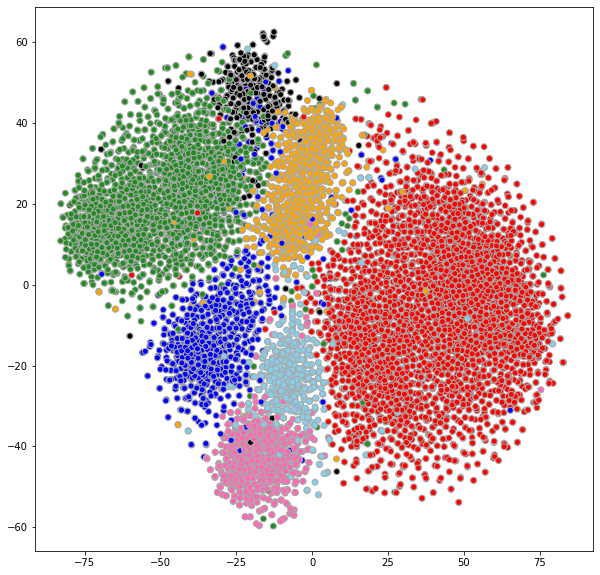

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
colors = ['hotpink', 'skyblue','red', 'orange', 'forestgreen', 'black', 'blue']

cl = []
for i in range(newmar.shape[0]):
    cl.append(colors[newlabels[i]])

def draw_edges(n):
    i = 0
    for e in nx.edges():
        #print(e)
        #print(w_embedded[e[0],:], w_embedded[e[1], :])
        x1 = w_embedded[e[0],0]
        y1 = w_embedded[e[0],1]
        x2 = w_embedded[e[1],0]
        y2 = w_embedded[e[1],1]
        a = [x1, x2]
        b = [y1, y2]
        plt.plot(a, b, c= [0.6, 0.6, 0.6], lw=0.2, zorder = 1)
        i+= 1
        if i > n:
            break
            
plt.figure(figsize=(10,10))
#draw_edges(G.number_of_nodes())
plt.scatter(w_embedded[:,0], w_embedded[:,1], c=cl, edgecolors= 'darkgray',zorder = 2)
#plt.colorbar()
plt.grid